# ***T5 MODEL***

## ***Import library***

In [1]:
!pip install --quiet transformers 
!pip install --quiet pytorch-lightning 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 113.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.1 MB/s eta 0:00:00


In [2]:
import seaborn as sns 
from transformers import AdamW, T5ForConditionalGeneration, T5TokenizerFast as T5Tokenizer
import pytorch_lightning as pl
import torch
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import textwrap
from pathlib import Path
import numpy as np
import seaborn as sns
from tqdm.auto import tqdm
from pylab import rcParams
import matplotlib.pyplot as plt 
from matplotlib import rc 
import pandas as pd
from sklearn.model_selection import train_test_split
import keras

In [3]:
import os

In [4]:
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

## ***Dataset***

In [5]:
df = pd.read_csv('/content/news_summary.csv',encoding='latin-1')
data = df
df = df[['text','ctext']]
df.columns=["summary", "text"]
df=df.dropna()
df.head()

,summary,text
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [6]:
train_df, test_df = train_test_split(df, test_size=0.1)
train_df.shape, test_df.shape

((3956, 2), (440, 2))

In [7]:
class NewsSummaryDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: T5Tokenizer,
        text_max_token_len: int = 512,
        summary_max_token_len: int = 128):
        
        self.tokenizer = tokenizer
        self.data = data
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index:int):
        data_row = self.data.iloc[index]
        text = data_row["text"]
        
        text_encoding = tokenizer(data_row["text"],max_length=self.text_max_token_len,
                                 padding="max_length", 
                                 truncation=True,
                                 return_attention_mask=True,
                                 add_special_tokens=True,
                                 return_tensors="pt")
        
        summary = data_row["summary"]
        summary_encoding = tokenizer(summary,max_length=self.summary_max_token_len,
                                 padding="max_length", 
                                 truncation=True,
                                 return_attention_mask=True,
                                 add_special_tokens=True,
                                 return_tensors="pt")
        
        labels= summary_encoding["input_ids"] 
        labels[labels == 0] = -100
        
        return dict(
            text=text, 
            summary=summary,
            text_input_ids=text_encoding["input_ids"].flatten(),
            text_attention_mask=text_encoding["attention_mask"].flatten(),
            labels=labels.flatten(),
            labels_attention_mask=summary_encoding["attention_mask"].flatten())
            

In [8]:
class NewsSummaryDataModule(pl.LightningDataModule):
    def __init__(self, 
                train_df:pd.DataFrame,
                test_df:pd.DataFrame,
                tokenizer:T5Tokenizer,
                batch_size: int = 8,
                text_max_token_len: int = 512,
                summary_max_token_len: int = 128):
        super().__init__()
        self.train_df=train_df
        self.test_df=test_df
        
        self.batch_size=batch_size
        self.tokenizer=tokenizer
        self.text_max_token_len=text_max_token_len
        self.summary_max_token_len= summary_max_token_len
    
    def setup(self, stage=None):
        self.train_dataset =  NewsSummaryDataset(
            self.train_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )
        self.test_dataset =  NewsSummaryDataset(
            self.test_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )
    
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2)
    
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2)
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2)
    
    

## ***LOAD T5 MODEL***

In [9]:
MODEL_NAME = "t5-base"

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


## ***Tokenizer***

In [10]:
text_token_counts, summary_token_counts = [],[]
for _, row in train_df.iterrows():
    text_token_count=len(tokenizer.encode(row['text']))
    text_token_counts.append(text_token_count)
    
    summary_token_count=len(tokenizer.encode(row['summary']))
    summary_token_counts.append(summary_token_count)

Token indices sequence length is longer than the specified maximum sequence length for this model (689 > 512). Running this sequence through the model will result in indexing errors


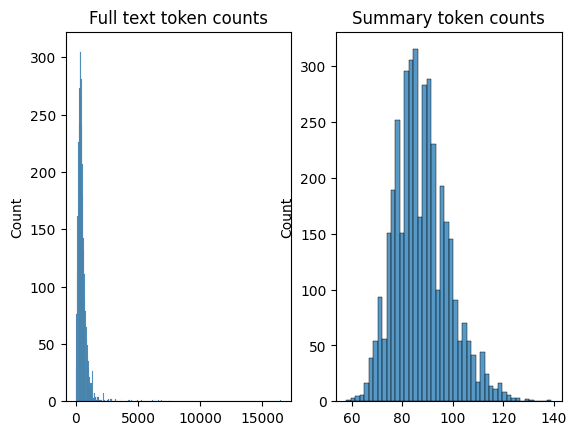

In [11]:
fig, (ax1,ax2) = plt.subplots(1,2)

sns.histplot(text_token_counts,ax=ax1)
ax1.set_title("Full text token counts")

sns.histplot(summary_token_counts,ax=ax2)
ax2.set_title("Summary token counts")

fig.show()


In [12]:
N_EPOCHS = 3
BATCH_SIZE = 8

data_module = NewsSummaryDataModule(train_df,test_df,tokenizer,batch_size=BATCH_SIZE)

## ***Model***

In [13]:
class NewsSummaryModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)
        
    def forward(self, inputs_ids, attention_mask, decoder_attention_mask, labels=None):
        output = self.model(inputs_ids,
                            attention_mask=attention_mask,
                            labels=labels,
                            decoder_attention_mask=decoder_attention_mask)
        return output.loss, output.logits
    
    def step(self, batch, batch_idx):
        input_ids=batch["text_input_ids"]
        attention_mask = batch["text_attention_mask"]
        labels=batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]
        
        loss, outputs = self.forward(inputs_ids=input_ids,
                             attention_mask=attention_mask,
                             decoder_attention_mask=labels_attention_mask,
                             labels=labels)
        return loss, outputs
    
    def training_step(self, batch, batch_idx):
        loss, outputs = self.step(batch, batch_idx)
        
        self.log("train_loss",loss, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, outputs = self.step(batch, batch_idx)
        self.log("val_loss",loss, prog_bar=True, logger=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        loss, outputs = self.step(batch, batch_idx)
        self.log("test_loss",loss, prog_bar=True, logger=True)
        return loss
    
    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.0001)
    

In [14]:
model = NewsSummaryModel()

In [16]:
checkpoint_callback = ModelCheckpoint(
                        dirpath="checkpoints",
                        filename="best-checkpoint",
                        save_top_k=1,
                        verbose=True, 
                        monitor="val_loss",
                        mode="min")
logger = TensorBoardLogger("lightning_logs", name="news-summary")

from pytorch_lightning.callbacks.progress import ProgressBar
class LitProgressBar(ProgressBar):

    def init_validation_tqdm(self):
        bar = super().init_validation_tqdm()
        bar.set_description('running validation ...')
        bar.refresh_rate=30
        return bar

bar = LitProgressBar()

trainer = pl.Trainer(logger=logger,
                    enable_checkpointing=checkpoint_callback,
                    max_epochs=N_EPOCHS,
                    accelerator="auto")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [17]:
trainer.fit(model,data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [18]:
trained_model = NewsSummaryModel.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
    )

In [19]:
trained_model = trained_model.to('cpu')

## ***Summarize***

In [20]:
def summarize(text):
    text_encoding = tokenizer(
        text,
        max_length=512,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
        )
    generated_ids = trained_model.model.generate(
        input_ids=text_encoding["input_ids"],
        attention_mask=text_encoding["attention_mask"],
        max_length=150,
        num_beams=2,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True)
    preds = [
        tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True) for gen_id in generated_ids
    ]
    return "".join(preds)
    

In [38]:
from nltk.translate.bleu_score import sentence_bleu
bleu = []
for i in range(15):
  sample_row = test_df.iloc[i]
  text = sample_row["text"]
  ref_summary = sample_row["summary"]
  model_summary = summarize(text)
  print('Original text :  \n', text)
  print('\nPredicted summary :  \n', model_summary)
  print('\nOriginal summary :  \n', ref_summary)
  bleuscore = sentence_bleu([ref_summary], model_summary, weights=(0.25,0.25,0.25,0.25))
  bleu.append(bleuscore)
  print(bleuscore)
  print('------------------------------------------------------------------------------------------')

Original text :  
 Washington, Mar 27 (PTI) A 38-year-old woman in the US, who was apprehended twice for allegedly trying to jump the White House fence last week, has been arrested for scaling a fence at the Treasury Building. Marci Anderson Wahl of Everett, Washington, was arrested after an alarm sounded at about 2:15 am yesterday when she scaled a fence at the Treasury Building, next to the White House. Police said Wahl has told them she was there to speak to US President Donald Trump, the CNN reported. She was charged with unlawful entry and contempt of court. Wahl was first arrested on March 21 last week for trying to jump the White House fence. Once in custody, it was determined that Wahl had been issued a "stay away" order for the White House complex after the incident. On March 21, officers saw Wahl walking and staring at the White House complex before discovering she had jumped a fence on the south side but got stuck. Officers found her hanging from the inside of the fence by h

In [28]:
text = "The architecture of MSU-Net is illustrated in Figure 1. MSU-Net has a contraction path and an expansion path. The network architecture follows encoder-decoder. In original U-Net, each block consists of two convolutional layers. However, there is still a drawback in this block. Due to the limitation of the receptive field, the network does not achieve better performance in feature extraction and feature restoration. The convolution blocks in encoder of the original U-Net are replaced with multi-scale blocks to obtain MSU-Net (encoder). The convolution blocks in decoder of the original U-Net are replaced with multi-scale blocks to obtain MSU-Net (decoder). The experimental results are illustrated in Table 2. In MSU-Net, the multi-scale block (37) is used to replace the all convolution block in the original U-Net. Multi-scale block enables encoder to extract more detailed information. Multi-scale block makes the features of decoder restoration more complete."
model_summary = summarize(text)
print('\nPredicted summary :  \n', model_summary)


Predicted summary :  
 The architecture of MSU-Net is illustrated in Figure 1. In original U-Net, each block consists of two convolutional layers. However, due to the limitation of the receptive field, the network does not achieve better performance in feature extraction and feature restoration. In MSU-Net, the multi-scale block (37) is used to replace the all convolution block in the original U-Net.


# ***SEQ2SEQ MODEL***

## ***Importing Libraries***

In [ ]:
from keras import backend as K
from keras.layers import Layer
from keras.layers import Concatenate
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, TimeDistributed, LSTM, Embedding, Input
from keras import Model
import re
import string
from nltk.corpus import stopwords
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

## ***Data Preprocessing***

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [ ]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
StopWords = set(stopwords.words('english'))
def preprocess(text):
    new_text = text.lower() 
    new_text = re.sub(r'\([^)]*\)', '', new_text) 
    new_text = re.sub('"','', new_text) 
    new_text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in new_text.split(" ")]) 
    new_text = re.sub(r"'s\b","",new_text) 
    new_text = re.sub("[^a-zA-Z]", " ", new_text) 
    new_text = ' '.join([word for word in new_text.split() if word not in StopWords]) 
    new_text = ' '.join([word for word in new_text.split() if len(word) >= 3]) 
    return new_text

#Apply above preprocessing to both text and summary separately.
text_cleaned = []
summ_cleaned = []
for text in data['text']:
    text_cleaned.append(preprocess(text))
for summary in data['headlines']:
    summ_cleaned.append(preprocess(summary))
clean_df = pd.DataFrame()
clean_df['text'] = text_cleaned
clean_df['headline'] = summ_cleaned

#Replacing empty string summaries with nan values and then dropping those datapoints.
clean_df['headline'].replace('', np.nan, inplace=True)
clean_df.dropna(axis=0, inplace=True)

#Adding START and END tokens to summaries for later use.
clean_df['headline'] = clean_df['headline'].apply(lambda x: '<START>' + ' '+ x + ' '+ '<END>')
for i in range(10):
    print('News: ', clean_df['text'][i])
    print('Headline:', clean_df['headline'][i])
    print('\n')

News:  administration union territory daman diu revoked order made compulsory women tie rakhis male colleagues occasion rakshabandhan august administration forced withdraw decision within hours issuing circular received flak employees slammed social media
Headline: <START> daman diu revokes mandatory rakshabandhan offices order <END>


News:  malaika arora slammed instagram user trolled divorcing rich man fun alimony life wearing short clothes going gym salon enjoying vacation user commented malaika responded certainly got get damn facts right spewing know nothing
Headline: <START> malaika slams user trolled divorcing rich man <END>


News:  indira gandhi institute medical sciences patna thursday made corrections marital declaration form changing virgin option unmarried earlier bihar health minister defined virgin unmarried woman consider term objectionable institute however faced strong backlash asking new recruits declare virginity form
Headline: <START> virgin corrected unmarried ig

In [ ]:
#Get max length of texts and summaries.
max_len_news = max([len(text.split()) for text in clean_df['text']])
max_len_headline = max([len(text.split()) for text in clean_df['headline']])
print(max_len_news, max_len_headline)

53 14


## ***Tokenization and Data Split***

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(clean_df['text'], clean_df['headline'], test_size=0.2, random_state=0)

#Keras tokenizer for news text.
news_tokenizer = Tokenizer()
news_tokenizer.fit_on_texts(list(X_train))
x_train_seq = news_tokenizer.texts_to_sequences(X_train)
x_test_seq = news_tokenizer.texts_to_sequences(X_test)
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len_news, padding='post') 
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len_news, padding='post')
#Vocab size of texts.
news_vocab = len(news_tokenizer.word_index) + 1

#Keras Tokenizer for summaries.
headline_tokenizer = Tokenizer()
headline_tokenizer.fit_on_texts(list(y_train))
y_train_seq = headline_tokenizer.texts_to_sequences(y_train)
y_test_seq = headline_tokenizer.texts_to_sequences(y_test)
y_train_pad = pad_sequences(y_train_seq, maxlen=max_len_headline, padding='post')
y_test_pad = pad_sequences(y_test_seq, maxlen=max_len_headline, padding='post')
#Vocab size of summaries.
headline_vocab = len(headline_tokenizer.word_index) + 1

## ***Attention Layer***

In [ ]:
class AttentionLayer(Layer):
    
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))

            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            fake_state = K.zeros_like(inputs)  
            fake_state = K.sum(fake_state, axis=[1, 2])  
            fake_state = K.expand_dims(fake_state)  
            fake_state = K.tile(fake_state, [1, hidden_size])  
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  

        """ Computing energy outputs """
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

## ***Encoder-Decoder Architecture***

In [ ]:
K.clear_session()

embedding_dim = 300 
latent_dim = 500 

encoder_input = Input(shape=(max_len_news, ))
encoder_emb = Embedding(news_vocab, embedding_dim, trainable=True)(encoder_input) #Embedding Layer

# Encoder
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
y_1, a_1, c_1 = encoder_lstm1(encoder_emb)

encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
y_2, a_2, c_2 = encoder_lstm2(y_1)

encoder_lstm3 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
encoder_output, a_enc, c_enc = encoder_lstm3(y_2)

#Decoder 
decoder_input = Input(shape=(None,))
decoder_emb = Embedding(headline_vocab, embedding_dim, trainable=True)(decoder_input)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
decoder_output, decoder_fwd, decoder_back = decoder_lstm(decoder_emb, initial_state=[a_enc, c_enc]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_output, decoder_output]) 

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_output, attn_out])

decoder_dense = TimeDistributed(Dense(headline_vocab, activation='softmax'))
decoder_output = decoder_dense(decoder_concat_input)

model = Model([encoder_input, decoder_input], decoder_output)
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 53)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 53, 300)      20888100    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 53, 500), (N 1602000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

In [ ]:
#Training the model with Early Stopping callback on val_loss.
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
callback = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
history=model.fit([x_train_pad,y_train_pad[:,:-1]], y_train_pad.reshape(y_train_pad.shape[0],y_train_pad.shape[1], 1)[:,1:] ,epochs=50,callbacks=[callback],batch_size=512, validation_data=([x_test_pad,y_test_pad[:,:-1]], y_test_pad.reshape(y_test_pad.shape[0],y_test_pad.shape[1], 1)[:,1:]))

Epoch 1/50
161/161 [==============================] - 207s 1s/step - loss: 4.8073 - val_loss: 4.3462
Epoch 2/50
161/161 [==============================] - 206s 1s/step - loss: 4.2998 - val_loss: 4.0381
Epoch 3/50
161/161 [==============================] - 208s 1s/step - loss: 3.9862 - val_loss: 3.7943
Epoch 4/50
161/161 [==============================] - 209s 1s/step - loss: 3.7020 - val_loss: 3.5962
Epoch 5/50
161/161 [==============================] - 208s 1s/step - loss: 3.4428 - val_loss: 3.4502
Epoch 6/50
161/161 [==============================] - 210s 1s/step - loss: 3.2190 - val_loss: 3.3321
Epoch 7/50
161/161 [==============================] - 210s 1s/step - loss: 3.0243 - val_loss: 3.2364
Epoch 8/50
161/161 [==============================] - 210s 1s/step - loss: 2.8511 - val_loss: 3.1845
Epoch 9/50
161/161 [==============================] - 209s 1s/step - loss: 2.6933 - val_loss: 3.1503
Epoch 10/50
161/161 [==============================] - 209s 1s/step - loss: 2.5474 - val_lo

## ***Summarize***

In [ ]:
#Encoder inference model with trained inputs and outputs.
encoder_model = Model(inputs=encoder_input, outputs=[encoder_output, a_enc, c_enc])

#Initialising state vectors for decoder.
decoder_initial_state_a = Input(shape=(latent_dim,))
decoder_initial_state_c = Input(shape=(latent_dim,))
decoder_hidden_state = Input(shape=(max_len_news, latent_dim))

#Decoder inference model
decoder_out, decoder_a, decoder_c = decoder_lstm(decoder_emb, initial_state=[decoder_initial_state_a, decoder_initial_state_c])
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state, decoder_out])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_out, attn_out_inf])

decoder_final = decoder_dense(decoder_inf_concat)
decoder_model = Model([decoder_input]+[decoder_hidden_state, decoder_initial_state_a, decoder_initial_state_c], [decoder_final]+[decoder_a, decoder_c])

In [ ]:
def decoded_sequence(input_seq):
    encoder_out, encoder_a, encoder_c = encoder_model.predict(input_seq) 

    next_input = np.zeros((1,1))
    next_input[0,0] = headline_tokenizer.word_index['start']
    output_seq = ''
    #Stopping condition to terminate loop when one summary is generated.
    stop = False
    while not stop:
        decoded_out, trans_state_a, trans_state_c = decoder_model.predict([next_input] + [encoder_out, encoder_a, encoder_c])
        output_idx = np.argmax(decoded_out[0, -1, :])
        if output_idx == headline_tokenizer.word_index['end']: 
            stop = True
        elif output_idx>0 and output_idx != headline_tokenizer.word_index['start'] :
            output_token = headline_tokenizer.index_word[output_idx] 
            output_seq = output_seq + ' ' + output_token 
        
        #Pass the current output index as input to next neuron.
        next_input[0,0] = output_idx
        #Continously update the transient state vectors in decoder.
        encoder_a, encoder_c = trans_state_a, trans_state_c
        
    return output_seq        

In [ ]:
predicted = []
for i in range(15):
    print('News:', X_test.iloc[i])
    print('Actual Headline:', y_test.iloc[i])
    print('Predicted Headline:', decoded_sequence(x_test_pad[i].reshape(1, max_len_news)))
    predicted.append(decoded_sequence(x_test_pad[i].reshape(1, max_len_news)).split())

News: qualcomm monday announced chinese court order banning import sale apple iphone iphone models china due software patent violations court found apple violated two qualcomm software patents around resizing photographs managing applications touchscreen apple however said iphones remain sale china
Actual Headline: <START> qualcomm wins import ban apple iphones china <END>
Predicted Headline:  qualcomm may pay china iphone sales report
News: congress appointed year old amit chavda new chief gujarat unit replacing year old bharatsinh solanki held post since december comes days congress president rahul gandhi said younger generations come forward take party leadership inspired gandhi words year old shantaram naik resigned goa congress chief
Actual Headline: <START> congress appoints old amit chavda new gujarat head <END>
Predicted Headline:  congress shares year old son congress
News: male nurse employed delhi institute liver biliary sciences booked allegedly stealing government hospital

In [ ]:
summaries = list(y_test)
references = []
for summ in summaries:
    ref = summ.split()
    ref.remove('<START>')
    ref.remove('<END>')
    references.append(ref)

In [ ]:
refs = []
smooth = SmoothingFunction().method4
for i in range(15):
    refs.append(references[i])
    print(refs, predicted[i])
    print(sentence_bleu(refs, predicted[i], weights=(0.25,0.25,0.25,0.25)))
    refs.remove(references[i])

[['qualcomm', 'wins', 'import', 'ban', 'apple', 'iphones', 'china']] ['qualcomm', 'may', 'pay', 'china', 'iphone', 'sales', 'report']
0.7311104457090247
[['congress', 'appoints', 'old', 'amit', 'chavda', 'new', 'gujarat', 'head']] ['congress', 'shares', 'year', 'old', 'son', 'congress']
0.5444460596606694
[['nurse', 'sells', 'stents', 'worth', 'stolen', 'hospital']] ['doctor', 'fined', 'lakh', 'kidney', 'kidney', 'kidney', 'bihar']
0
[['govt', 'announces', 'aadhaar', 'like', 'unique', 'businesses']] ['govt', 'allocates', 'crore', 'rural', 'rural', 'areas']
0.6389431042462724
[['slams', 'facebook', 'failing', 'tackle', 'human', 'trafficking']] ['facebook', 'asks', 'people', 'find', 'facebook', 'data', 'alcohol']
0.6147881529512643
[['everything', 'get', 'triple', 'talaq', 'bill', 'passed', 'govt']] ['cabinet', 'approves', 'bill', 'triple', 'talaq', 'bill']
0.40027649424491646
[['scientists', 'blew', 'equipment', 'create', 'strongest', 'magnetic', 'field']] ['scientists', 'record', 'reco

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
